# CS 109A/AC 209A/STAT 121A Data Science: Final Project
**Harvard University**<br>
**Fall 2016**<br>
**Instructors:** W. Pan, P. Protopapas, K. Rader<br>
**Members: ** Shawn Pan, Xinyuan (Amy) Wang, Ming-long Wu

## Remark - 043_reduce_dim.ipynb ##
- Check scatter plots of several predictor matrix
- Recursive Feature Selection


In [6]:
import time
import pandas as pd
import numpy as np
import scipy as sp
from scipy.signal import savgol_filter
from scipy.stats import mode
import goslate
from langdetect import detect
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import dates
from matplotlib import colors
import matplotlib.dates as mdates
from datetime import datetime
from collections import Counter
from mpl_toolkits.basemap import Basemap
import statsmodels.api as sm
from sklearn import preprocessing
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
%matplotlib inline

### Load data

In [2]:
# Load listing data
listing = pd.read_csv('../../Data/data_preprocessed.csv')
print(listing.columns.values)
listing.head()

['id' 'host_since' 'zipcode' 'latitude' 'longitude' 'accommodates'
 'bathrooms' 'bedrooms' 'beds' 'guests_included' 'minimum_nights'
 'maximum_nights' 'availability_30' 'availability_60' 'availability_90'
 'availability_365' 'number_of_reviews' 'first_review' 'last_review'
 'review_scores_rating' 'review_scores_accuracy'
 'review_scores_cleanliness' 'review_scores_checkin'
 'review_scores_communication' 'review_scores_location'
 'review_scores_value' 'host_listing_count' 'price' 'property_type_0'
 'property_type_1' 'property_type_2' 'property_type_3' 'property_type_4'
 'property_type_5' 'room_type_0' 'room_type_1' 'room_type_2' 'bed_type_0'
 'bed_type_1' 'bed_type_2' 'bed_type_3' 'bed_type_4']


,id,host_since,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,guests_included,...,property_type_4,property_type_5,room_type_0,room_type_1,room_type_2,bed_type_0,bed_type_1,bed_type_2,bed_type_3,bed_type_4
0,1069266,1926,10022.0,40.756852,-73.964754,2,1.0,1.0,1.0,2,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1846722,1625,10532.0,40.830599,-73.941014,10,1.0,3.0,3.0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2061725,1831,11221.0,40.692189,-73.924120,2,1.0,1.0,2.0,1,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,44974,953,10011.0,40.734751,-74.002592,2,1.0,1.0,1.0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4701675,2479,10011.0,40.745282,-73.997836,2,1.0,1.0,2.0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Check scatter plots of several predictor matrix
- **None of the pair checked has high correlation.**

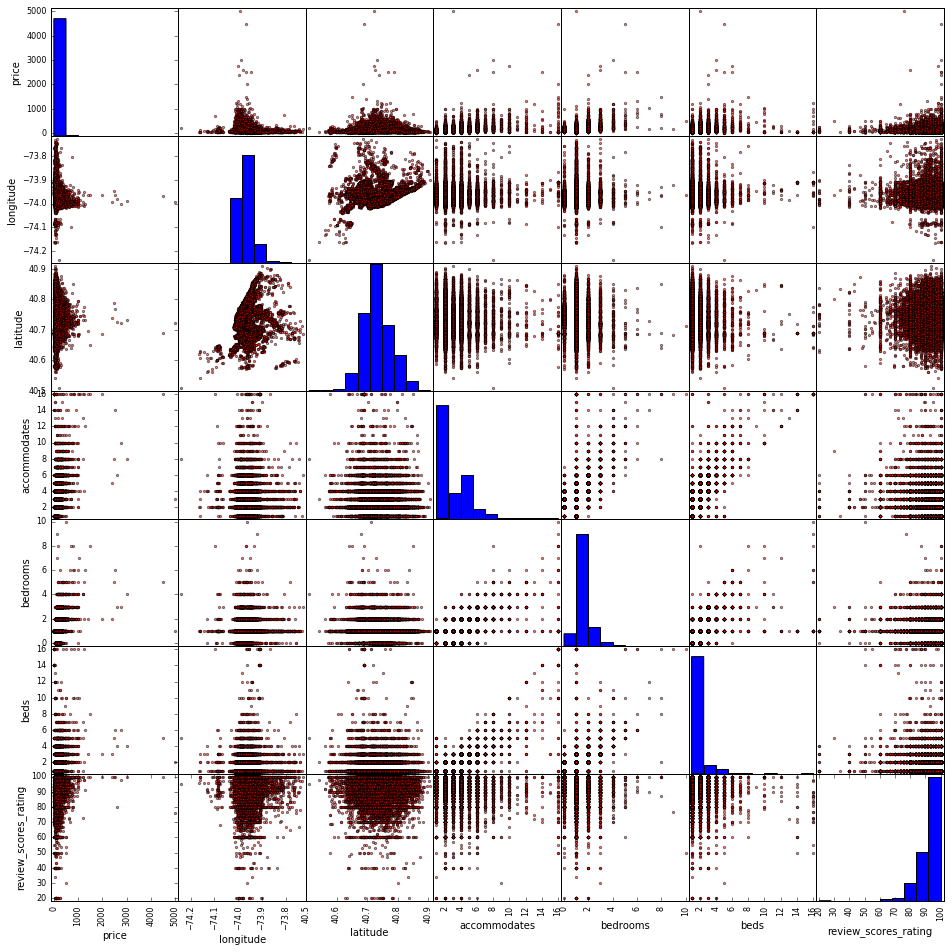

In [3]:
# Scatter plot of several predictors
scattercols = ['price','longitude','latitude','accommodates','bedrooms','beds','review_scores_rating']
axs = pd.scatter_matrix(listing[scattercols],
figsize=(16, 16), c='red')

### Principal Component Analysis for dimension reduction ###
- Performs PCA by checking variance explained.

In [11]:
# Get x and y
x = listing
x = x.drop('price', axis=1)
x = x.drop('id', axis=1)
y = listing['price']
print x.shape
print y.shape

(18615, 40)
(18615,)


In [26]:
# Apply PCA to data and get the top 150 axes of maximum variation
num_com = x.shape[1]
pca = PCA(n_components=num_com)
pca.fit(x)


PCA(copy=True, n_components=40, whiten=False)

In [27]:
pca.explained_variance_ratio_

array([  9.99999999e-01,   6.56771519e-10,   5.60146676e-10,
         1.22920495e-10,   3.10566165e-11,   2.56533515e-11,
         1.24364722e-12,   4.39020562e-13,   1.26082546e-13,
         6.33500676e-14,   1.32439659e-14,   1.15504899e-14,
         9.16640632e-15,   7.33593352e-15,   1.53683459e-15,
         1.40960156e-15,   1.34680971e-15,   9.73416814e-16,
         7.68041318e-16,   7.55331625e-16,   5.84825053e-16,
         5.14536324e-16,   3.96408142e-16,   3.80587715e-16,
         2.15447147e-16,   1.56961795e-16,   1.07436897e-16,
         6.00201514e-17,   5.64061519e-17,   2.64642390e-17,
         1.65328610e-17,   1.36997364e-17,   7.10993347e-18,
         5.72207249e-18,   3.20354529e-18,   3.14601423e-18,
         7.09093604e-19,   9.98379118e-33,   9.98379118e-33,
         9.98379118e-33])

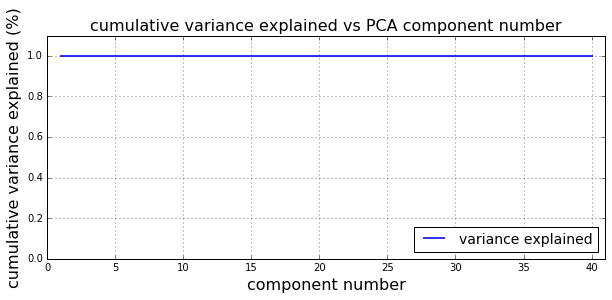

In [28]:
variance_cumulative = np.empty(num_com)
for idx in range(num_com):
    variance_cumulative[idx] = sum(pca.explained_variance_ratio_[0:idx+1])

# Plot weekday average price in 2015
fig1, ax1 = plt.subplots(1, 1, figsize=(10, 4))
ax1.plot(range(1,num_com+1),variance_cumulative, c='blue', label='variance explained', linewidth=2.0, alpha = 0.8)
ax1.set_xlabel('component number', fontsize=16)
ax1.set_ylabel('cumulative variance explained (%)', fontsize=16)
ax1.set_title('cumulative variance explained vs PCA component number', fontsize=16)
ax1.set_xlim([0,41])
ax1.set_ylim([0,1.1])
plt.legend(loc = 4, fontsize = 14)
plt.grid()
plt.show()

**Here, we see that the first component already explained 99.9% variance. We could have chosen just one component in PCA here. But we emperically choose three components to be more inclusive.**

In [29]:
# Apply PCA to data and get the top 3 axes of maximum variation
num_com = 3
pca = PCA(n_components=num_com)
pca.fit(x)
print('Total variance explained: ' + str(sum(pca.explained_variance_ratio_[0:num_com])) + '%')

# Project to the data onto the three axes
x_pca = pca.transform(x)
print('Reduced x dimension:' + str(x_pca.shape))

Total variance explained: 0.999999999818%
Reduced x dimension:(18615, 3)


### Split PCA reduced data for training and testing data###

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.3, random_state=0)

In [48]:
# RFE
#RFE(estimator, n_features_to_select=None, step=1, verbose=0)
model = LinearRegression()

selector = RFE(model, n_features_to_select=1)
selector.fit(x, np.log(y))
print selector.support_
print selector.ranking_

[False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
[39 37  2  1 14  8  5 15 21 27 40 28 34 35 33 31 38 36 29 24 17 30 32 13 16
 25 23 20  6  9  7 10  3 12  4 19 11 26 22 18]


In [49]:
#ranking - if you keep out all predictors except 1
print "Order of Predictor Importance:"
print "--------------------"
for c in x.columns[np.argsort(selector.ranking_)]:
    print c

Order of Predictor Importance:
--------------------
longitude
latitude
room_type_0
room_type_2
bedrooms
property_type_2
property_type_4
bathrooms
property_type_3
property_type_5
bed_type_1
room_type_1
review_scores_location
accommodates
beds
review_scores_value
review_scores_cleanliness
bed_type_4
bed_type_0
property_type_1
guests_included
bed_type_3
property_type_0
review_scores_accuracy
host_listing_count
bed_type_2
minimum_nights
availability_30
review_scores_rating
review_scores_checkin
number_of_reviews
review_scores_communication
availability_365
availability_60
availability_90
last_review
zipcode
first_review
host_since
maximum_nights


In [51]:
# Check predictors selected if we set n_features_to_select=20
model = LinearRegression()
selector = RFE(model, n_features_to_select=20)
selector.fit(x, np.log(y))

print x.columns[selector.support_]
x2 = x[x.columns[selector.support_]]


Index([u'latitude', u'longitude', u'accommodates', u'bathrooms', u'bedrooms',
       u'beds', u'review_scores_cleanliness', u'review_scores_location',
       u'review_scores_value', u'property_type_1', u'property_type_2',
       u'property_type_3', u'property_type_4', u'property_type_5',
       u'room_type_0', u'room_type_1', u'room_type_2', u'bed_type_0',
       u'bed_type_1', u'bed_type_4'],
      dtype='object')


### Use Lasso to shrink the predictors ##
- First, we split our training dataset into train data and test data.

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x2, np.log(y), test_size=0.3, random_state=0)

# The following has not been completed!!

In [52]:
model_lasso = Lasso()
results = model_lasso.fit(x_train,y_train)
print (results.coef_[2])

0.0


In [ ]:
model_lassocv = LassoCV()
results = model_lassocv.fit(x_train,y_train)
print (model_lasso.coef_[2])

In [ ]:
n_est = 300
tuned_parameters = {
"n_estimators": [ n_est ],
"max_depth" : [ 4 ],
"learning_rate": [ 0.01 ],
"min_samples_split" : [ 1 ],
"loss" : [ 'ls', 'lad' ]
}
gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
# scoring='median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_

In [ ]:
#Feature Extraction:
#Use the features we decided last time
features = ['zipcode', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 
            'bathrooms', 'bedrooms', 'beds', 'bed_type', 'number_of_reviews', 'review_scores_rating',
            'review_scores_accuracy', 'review_scores_cleanliness', 
            'review_scores_checkin', 'review_scores_communication', 
            'review_scores_location', 'review_scores_value', 'host_listing_count']

df_x = listing[features]
df_x.head()

## Select features, log(price) and one-hot encoding

In [ ]:
# Get features from dataframe and add log(price) as response variable
df_cleaned = listing1[features]
df_cleaned['log_price'] = pd.Series(np.log(listing1['price']),index=listing1.index)
df_cleaned.head()